In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import geopandas as gpd
import osmnx as ox
import networkx as nx
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.ops import cascaded_union
import fiona
fiona.supported_drivers
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 12) # (w, h)
ox.config(log_console=True, use_cache=True)
ox.__version__

'0.9'

In [2]:
# Merge daily file into one January file 
import glob
path = r'G:/My Drive/Uber movement/Codes and datasets/Datasets/DC_2018Q1'                     
all_files = glob.glob(path + "/*.csv")
lst = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    lst.append(df)
    print(filename,df.shape)

df_Q1 = pd.concat(lst, axis=0, ignore_index=True)
print(df_Q1.shape)

G:/My Drive/Uber movement/Codes and datasets/Datasets/DC_2018Q1\Travel_Times_172018.csv (528, 8)
G:/My Drive/Uber movement/Codes and datasets/Datasets/DC_2018Q1\Travel_Times_162018.csv (519, 8)
G:/My Drive/Uber movement/Codes and datasets/Datasets/DC_2018Q1\Travel_Times_192018.csv (508, 8)
G:/My Drive/Uber movement/Codes and datasets/Datasets/DC_2018Q1\Travel_Times_182018.csv (503, 8)
G:/My Drive/Uber movement/Codes and datasets/Datasets/DC_2018Q1\Travel_Times_132018.csv (522, 8)
G:/My Drive/Uber movement/Codes and datasets/Datasets/DC_2018Q1\Travel_Times_2112018.csv (537, 8)
G:/My Drive/Uber movement/Codes and datasets/Datasets/DC_2018Q1\Travel_Times_2102018.csv (539, 8)
G:/My Drive/Uber movement/Codes and datasets/Datasets/DC_2018Q1\Travel_Times_122018.csv (503, 8)
G:/My Drive/Uber movement/Codes and datasets/Datasets/DC_2018Q1\Travel_Times_1222018.csv (503, 8)
G:/My Drive/Uber movement/Codes and datasets/Datasets/DC_2018Q1\Travel_Times_1252018.csv (523, 8)
G:/My Drive/Uber movement/

G:/My Drive/Uber movement/Codes and datasets/Datasets/DC_2018Q1\Travel_Times_2122018.csv (528, 8)
G:/My Drive/Uber movement/Codes and datasets/Datasets/DC_2018Q1\Travel_Times_212018.csv (529, 8)
G:/My Drive/Uber movement/Codes and datasets/Datasets/DC_2018Q1\Travel_Times_142018.csv (498, 8)
(47384, 8)


In [3]:
df_Q1['Date']=df_Q1['Date Range'].apply(lambda x: x[:9].strip())
print(df_Q1.columns)
print(df_Q1.info())
df_Q1.to_csv('G:/My Drive/Uber movement/Codes and datasets/Datasets/DC_2018Q1.csv', index=False)

Index(['Origin Movement ID', 'Origin Display Name', 'Destination Movement ID',
       'Destination Display Name', 'Date Range', 'Mean Travel Time (Seconds)',
       'Range - Lower Bound Travel Time (Seconds)',
       'Range - Upper Bound Travel Time (Seconds)', 'Date'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47384 entries, 0 to 47383
Data columns (total 9 columns):
Origin Movement ID                           47384 non-null int64
Origin Display Name                          47384 non-null object
Destination Movement ID                      47384 non-null int64
Destination Display Name                     47384 non-null object
Date Range                                   47384 non-null object
Mean Travel Time (Seconds)                   47384 non-null int64
Range - Lower Bound Travel Time (Seconds)    47384 non-null int64
Range - Upper Bound Travel Time (Seconds)    47384 non-null int64
Date                                         47384 non-null object
d

In [4]:
# Convert the datetime format 
from datetime import datetime 
df_Q1['Date']=df_Q1['Date'].apply(lambda x: datetime.strptime(x,'%m/%d/%Y').strftime('%Y-%m-%d'))
print(df_Q1['Date'].head())

0    2018-01-07
1    2018-01-07
2    2018-01-07
3    2018-01-07
4    2018-01-07
Name: Date, dtype: object


In [5]:
# Weater feature extraction
df_WTR=pd.read_csv('G:/My Drive/Uber movement/Codes and datasets/Datasets/1731302.csv')
print(df_WTR.info())
print(df_WTR.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 44 columns):
STATION            90 non-null object
NAME               90 non-null object
LATITUDE           90 non-null float64
LONGITUDE          90 non-null float64
ELEVATION          90 non-null float64
DATE               90 non-null object
AWND               90 non-null float64
AWND_ATTRIBUTES    90 non-null object
PRCP               90 non-null float64
PRCP_ATTRIBUTES    90 non-null object
SNOW               90 non-null float64
SNOW_ATTRIBUTES    90 non-null object
SNWD               90 non-null float64
SNWD_ATTRIBUTES    90 non-null object
TAVG               90 non-null int64
TAVG_ATTRIBUTES    90 non-null object
TMAX               90 non-null int64
TMAX_ATTRIBUTES    90 non-null object
TMIN               90 non-null int64
TMIN_ATTRIBUTES    90 non-null object
WDF2               90 non-null int64
WDF2_ATTRIBUTES    90 non-null object
WDF5               89 non-null float64
WDF5_ATTRIBUTES    

In [6]:
# Merge weather with January data
def wtrmerge(df1,df2):
    columns=['AWND','PRCP','SNOW','SNWD','TAVG','TMAX','TMIN','WSF2','WSF5',
             'WT01','WT02','WT03','WT04','WT05','WT06','WT08','WT09']
    for c in columns: 
        f_c=dict(zip(df1['DATE'],df1[c]))
        df2[c]=[f_c.get(str(v),'NaN') for v in df2['Date']]    
    return
wtrmerge(df_WTR,df_Q1)
df_Q1.info()
df_Q1.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47384 entries, 0 to 47383
Data columns (total 26 columns):
Origin Movement ID                           47384 non-null int64
Origin Display Name                          47384 non-null object
Destination Movement ID                      47384 non-null int64
Destination Display Name                     47384 non-null object
Date Range                                   47384 non-null object
Mean Travel Time (Seconds)                   47384 non-null int64
Range - Lower Bound Travel Time (Seconds)    47384 non-null int64
Range - Upper Bound Travel Time (Seconds)    47384 non-null int64
Date                                         47384 non-null object
AWND                                         47384 non-null float64
PRCP                                         47384 non-null float64
SNOW                                         47384 non-null float64
SNWD                                         47384 non-null float64
TAVG                 

,Origin Movement ID,Origin Display Name,Destination Movement ID,Destination Display Name,Date Range,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),Date,AWND,...,WSF2,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09
47379,186,"20001, Northwest Washington, Washington",553,"4900 Seminary Road, Alexandria West, Alexandria","1/4/2018 - 1/4/2018, Every day, Daily Average",845,624,1142,2018-01-04,19.91,...,35.1,49.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
47380,186,"20001, Northwest Washington, Washington",554,"1300 North Beauregard Street, Alexandria West,...","1/4/2018 - 1/4/2018, Every day, Daily Average",884,656,1190,2018-01-04,19.91,...,35.1,49.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
47381,186,"20001, Northwest Washington, Washington",555,"5900 Atteentee Road, Springfield","1/4/2018 - 1/4/2018, Every day, Daily Average",1276,1045,1557,2018-01-04,19.91,...,35.1,49.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
47382,186,"20001, Northwest Washington, Washington",556,"7800 Montvale Way, McLean","1/4/2018 - 1/4/2018, Every day, Daily Average",1510,1197,1903,2018-01-04,19.91,...,35.1,49.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
47383,186,"20001, Northwest Washington, Washington",558,"4000 Wheeler Avenue, Seminary Hill, Alexandria","1/4/2018 - 1/4/2018, Every day, Daily Average",1373,966,1951,2018-01-04,19.91,...,35.1,49.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [7]:
# Datetime features extraction
df_Q1['Date']=pd.to_datetime(df_Q1['Date'],format='%Y-%m-%d')
df_Q1['Month']=getattr(df_Q1['Date'].dt, 'month').astype(int)
df_Q1['DOW']=getattr(df_Q1['Date'].dt, 'dayofweek').astype(int) # The day of the week with Monday=0, Sunday=6.
print(df_Q1['Month'].head())
print(df_Q1['DOW'].head())
df_Q1.head()

0    1
1    1
2    1
3    1
4    1
Name: Month, dtype: int32
0    6
1    6
2    6
3    6
4    6
Name: DOW, dtype: int32


,Origin Movement ID,Origin Display Name,Destination Movement ID,Destination Display Name,Date Range,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),Date,AWND,...,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,Month,DOW
0,186,"20001, Northwest Washington, Washington",1,"5400 Arnold Avenue Southwest, Southwest Washin...","1/7/2018 - 1/7/2018, Every day, Daily Average",645,480,865,2018-01-07,8.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,6
1,186,"20001, Northwest Washington, Washington",2,"1400 Juniper Street Northwest, Northwest Washi...","1/7/2018 - 1/7/2018, Every day, Daily Average",1580,1292,1931,2018-01-07,8.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,6
2,186,"20001, Northwest Washington, Washington",3,"4800 Canal Road Northwest, Northwest Washingto...","1/7/2018 - 1/7/2018, Every day, Daily Average",1173,947,1452,2018-01-07,8.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,6
3,186,"20001, Northwest Washington, Washington",4,"2700 Unicorn Lane Northwest, Northwest Washing...","1/7/2018 - 1/7/2018, Every day, Daily Average",1634,1403,1902,2018-01-07,8.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,6
4,186,"20001, Northwest Washington, Washington",5,"4500 Q Place Northwest, Northwest Washington, ...","1/7/2018 - 1/7/2018, Every day, Daily Average",913,720,1157,2018-01-07,8.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,6


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 558 entries, 0 to 557
Data columns (total 3 columns):
MOVEMENT_ID     558 non-null object
DISPLAY_NAME    558 non-null object
geometry        558 non-null object
dtypes: object(3)
memory usage: 13.2+ KB
1400 Juniper Street Northwest, Northwest Washington, Washington


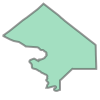

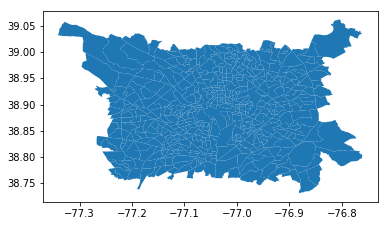

In [6]:
#Geometry feature extraction
#import washington_DC_censustracts
WDC_GEO=gpd.read_file ('G:/My Drive/Uber movement/Codes and datasets/Datasets/washington_DC_censustracts.json')
WDC_GEO.columns
WDC_GEO.info()
WDC_GEO.plot()
print(WDC_GEO['DISPLAY_NAME'][1])
WDC_GEO['geometry'][1]

In [7]:
# get a graph for polygon 
G = ox.graph_from_polygon(WDC_GEO['geometry'][1], network_type='drive_service', truncate_by_edge=False, simplify=False, retain_all=True)
# convert graph to UTM zone
G_proj = ox.project_graph(G)
# convert to geodataframe
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
# what sized area does our network cover in square meters?
graph_area_m = nodes_proj.unary_union.convex_hull.area
print('graph_area_m2:',graph_area_m)

graph_area_m2: 2910236.4068359076


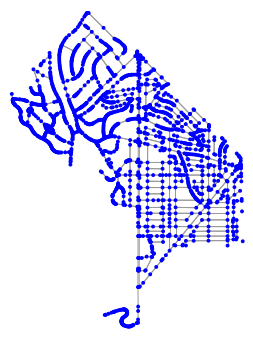

blue_retain 325
red_clean 1707


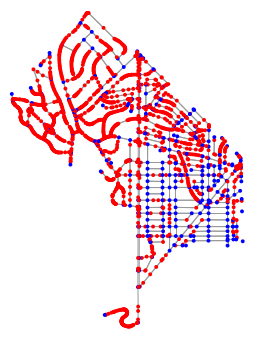

blue_retain 325
red_clean 0


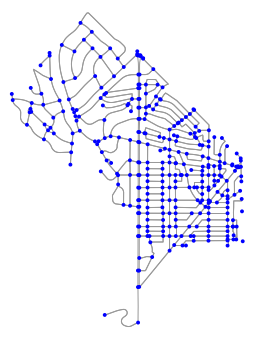

base_stat of origin graph: {'n': 2032, 'm': 4240, 'k_avg': 4.173228346456693, 'intersection_count': 2002, 'streets_per_node_avg': 2.172244094488189, 'streets_per_node_counts': {0: 2, 1: 28, 2: 1709, 3: 204, 4: 89}, 'streets_per_node_proportion': {0: 0.000984251968503937, 1: 0.013779527559055118, 2: 0.8410433070866141, 3: 0.10039370078740158, 4: 0.043799212598425195}, 'edge_length_total': 85165.40099999995, 'edge_length_avg': 20.086179481132064, 'street_length_total': 45074.283999999985, 'street_length_avg': 20.423327594019025, 'street_segments_count': 2207, 'node_density_km': 698.2250635127092, 'intersection_density_km': 687.9166226143916, 'edge_density_km': 29264.083426333815, 'street_density_km': 15488.18642159935, 'circuity_avg': 0.9995638759674357, 'self_loop_proportion': 0.0, 'clean_intersection_count': 299, 'clean_intersection_density_km': 102.74079428656498}
232
base_stat of clen_intersection graph: {'n': 325, 'm': 934, 'k_avg': 5.747692307692308, 'intersection_count': 295, 'str

In [8]:
#Use OSMnx to topologically correct and simplify street networks- nodes
fig, ax = ox.plot_graph(G, node_color='b', node_zorder=3)
# show which nodes we'd remove if we simplify it
nc = ['b' if ox.is_endpoint(G, node) else 'r' for node in G.nodes()]
print('blue_retain',nc.count('b'))
print('red_clean',nc.count('r'))
fig, ax = ox.plot_graph(G, node_color=nc, node_zorder=3)
#Simplify a graph’s topology by removing all nodes that are not intersections or dead-ends.
G2 = G.copy()
G2 = ox.simplify_graph(G2)
nc_G2 = ['b' if ox.is_endpoint(G2, node) else 'r' for node in G2.nodes()]
print('blue_retain',nc_G2.count('b'))
print('red_clean',nc_G2.count('r'))
fig, ax = ox.plot_graph(G2, node_color='b', node_zorder=3)
# show some basic stats about the network
base_stat=ox.basic_stats(G_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')
print('base_stat of origin graph:', base_stat)
# clean up the intersections and extract their xy coords
G2_proj = ox.project_graph(G2)
intersections = ox.clean_intersections(G2_proj, tolerance=15, dead_ends=False)
print(len(intersections))
base_stat_G2=ox.basic_stats(G2_proj, area=graph_area_m, clean_intersects=False, circuity_dist='euclidean')
if base_stat_G2['intersection_count']>0:
    base_stat_G2=ox.basic_stats(G2_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')
else:
    base_stat_G2['clean_intersection_count']=0
print('base_stat of clen_intersection graph:', base_stat_G2)

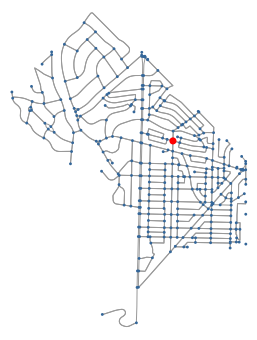

In [9]:
G2_extd_stat=ox.extended_stats(G2_proj, ecc=True, bc=True, cc=True)

max_node, max_bc = max(G2_extd_stat['betweenness_centrality'].items(), key=lambda x: x[1])
nc = ['r' if node==max_node else '#336699' for node in G2_proj.nodes()]
ns = [50 if node==max_node else 8 for node in G2_proj.nodes()]
fig, ax = ox.plot_graph(G2_proj, node_size=ns, node_color=nc, node_zorder=2)
#plt.title('Max Betweenness Centrality In The Origin ')

In [10]:
# extract DC geometry feature from polygons
def wdcgeofeature(df):
    garea=[]
    cintc=[]
    cintd=[]
    stlen=[]
    stden=[]
    bcnod=[]
    for i in df.index:
        P = ox.graph_from_polygon(df['geometry'][i], network_type='drive_service', truncate_by_edge=False, simplify=False, retain_all=True, name=i)
# convert graph to UTM zone
        P_proj = ox.project_graph(P)
# convert to geodataframe
        nodes_proj = ox.graph_to_gdfs(P_proj, edges=False)
# what sized area does our network cover in square meters?
        graph_area_m = nodes_proj.unary_union.convex_hull.area
#Simplify a graph’s topology by removing all nodes that are not intersections or dead-ends.
        P2 = P.copy()
        P2 = ox.simplify_graph(P2)
        P2_proj = ox.project_graph(P2)
        base_stat=ox.basic_stats(P2_proj, area=graph_area_m, clean_intersects=False, circuity_dist='euclidean')
        if base_stat['intersection_count']>0:
            base_stat=ox.basic_stats(P2_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')
        else:
            base_stat['clean_intersection_count']=0
        extd_stat=ox.extended_stats(P2_proj, ecc=True, bc=True, cc=True)
        mx_nd, mx_bc = max(extd_stat['betweenness_centrality'].items(), key=lambda x: x[1])
        bcnod.append(mx_nd)
        garea.append(graph_area_m)
        cintc.append(base_stat['clean_intersection_count'])
        cintd.append(base_stat['clean_intersection_density_km'])
        stlen.append(base_stat['street_length_total'])
        stden.append(base_stat['street_density_km'])
    df['graph_area_m']=garea
    df['clean_intersection_count']=cintc
    df['clean_intersection_density_km']=cintd
    df['street_length_total']=stlen
    df['street_density_km']=stden
    df['mxbc_node']=bcnod
    df['centroid']=df.centroid
    return
wdcgeofeature(WDC_GEO)
WDC_GEO.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 558 entries, 0 to 557
Data columns (total 10 columns):
MOVEMENT_ID                      558 non-null object
DISPLAY_NAME                     558 non-null object
geometry                         558 non-null object
graph_area_m                     558 non-null float64
clean_intersection_count         558 non-null int64
clean_intersection_density_km    558 non-null float64
street_length_total              558 non-null float64
street_density_km                558 non-null float64
mxbc_node                        558 non-null int64
centroid                         558 non-null object
dtypes: float64(4), int64(2), object(4)
memory usage: 43.7+ KB


In [11]:
# extract nodes of centroid in polygons
def wdcgeofeature2(df):
    cennd=[]
    for i in df.index:
        P = ox.graph_from_polygon(df['geometry'][i], network_type='drive_service', truncate_by_edge=False, simplify=False, retain_all=True, name=i)
        P2 = ox.simplify_graph(P)
#        P2_proj = ox.project_graph(P2)
        cor=(df['centroid'][i].x,df['centroid'][i].y)
        rcor=tuple(reversed(cor))
        node = ox.get_nearest_node(P2, rcor)
        cennd.append(node)
    df['centrnode']=cennd
    return
wdcgeofeature2(WDC_GEO)
WDC_GEO.head(10)

,MOVEMENT_ID,DISPLAY_NAME,geometry,graph_area_m,clean_intersection_count,clean_intersection_density_km,street_length_total,street_density_km,mxbc_node,centroid,centrnode
0,1,"5400 Arnold Avenue Southwest, Southwest Washin...","(POLYGON ((-77.04800899999999 38.841266, -77.0...",5.015114e+06,231,46.060764,52675.320,10503.313887,49725080,POINT (-77.02294130943518 38.84052085153819),49780370
1,2,"1400 Juniper Street Northwest, Northwest Washi...","(POLYGON ((-77.05162300000001 38.987145, -77.0...",2.910236e+06,232,79.718610,45074.284,15488.186422,49745571,POINT (-77.03783577191703 38.98454887155413),49781497
2,3,"4800 Canal Road Northwest, Northwest Washingto...","(POLYGON ((-77.11975099999999 38.93435, -77.11...",2.583289e+06,78,30.194068,22759.985,8810.468252,49799918,POINT (-77.10750440345829 38.92796868986088),49749809
3,4,"2700 Unicorn Lane Northwest, Northwest Washing...","(POLYGON ((-77.071647 38.971786, -77.071250000...",5.283216e+06,131,24.795505,39295.185,7437.739980,49788157,POINT (-77.05407807862206 38.97350188393705),49826388
4,5,"4500 Q Place Northwest, Northwest Washington, ...","(POLYGON ((-77.100859 38.911209, -77.099577 38...",1.779070e+06,98,55.084950,21691.919,12192.839593,49743089,POINT (-77.08756121676936 38.91079508823327),49743495
5,6,"Ridge Road Northwest, Northwest Washington, Wa...","(POLYGON ((-77.069425 38.954336, -77.069312999...",3.461076e+06,87,25.136695,28092.675,8116.747173,49731251,POINT (-77.05450194652471 38.95381695565449),49731251
6,7,"4500 Ohio Drive Southwest, Southwest Washingto...","(POLYGON ((-77.064696 38.891852, -77.064626 38...",1.579999e+07,304,19.240516,90932.027,5755.194547,4015442034,POINT (-77.03521796880034 38.88015568908613),3001694491
7,8,"0 H Street Northwest, Northwest Washington, Wa...","(POLYGON ((-77.021918 38.902521, -77.021514999...",3.319001e+05,39,117.505255,7870.612,23713.801773,3001288930,POINT (-77.01361182786752 38.9008608020275),5441148094
8,9,"1800 Upshur Street Northwest, Northwest Washin...","(POLYGON ((-77.05211300000001 38.937994, -77.0...",2.619496e+06,71,27.104448,22234.713,8488.163585,49765793,POINT (-77.04245146320704 38.94524943927313),49768085
9,10,"1500 30th Street Northwest, Northwest Washingt...","(POLYGON ((-77.06926900000001 38.900582, -77.0...",3.201272e+06,133,41.545982,25718.431,8033.815625,49797171,POINT (-77.06076728435676 38.90573018557915),49781748


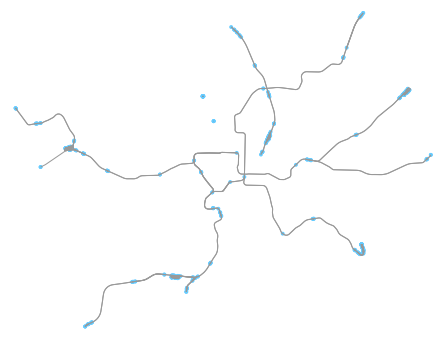

,MOVEMENT_ID,DISPLAY_NAME,geometry,graph_area_m,clean_intersection_count,clean_intersection_density_km,street_length_total,street_density_km,mxbc_node,centroid,centrnode,railway,railsubway_density_km
0,1,"5400 Arnold Avenue Southwest, Southwest Washin...","(POLYGON ((-77.04800899999999 38.841266, -77.0...",5.015114e+06,231,46.060764,52675.320,10503.313887,49725080,POINT (-77.02294130943518 38.84052085153819),49780370,0,0.0
1,2,"1400 Juniper Street Northwest, Northwest Washi...","(POLYGON ((-77.05162300000001 38.987145, -77.0...",2.910236e+06,232,79.718610,45074.284,15488.186422,49745571,POINT (-77.03783577191703 38.98454887155413),49781497,0,0.0
2,3,"4800 Canal Road Northwest, Northwest Washingto...","(POLYGON ((-77.11975099999999 38.93435, -77.11...",2.583289e+06,78,30.194068,22759.985,8810.468252,49799918,POINT (-77.10750440345829 38.92796868986088),49749809,0,0.0
3,4,"2700 Unicorn Lane Northwest, Northwest Washing...","(POLYGON ((-77.071647 38.971786, -77.071250000...",5.283216e+06,131,24.795505,39295.185,7437.739980,49788157,POINT (-77.05407807862206 38.97350188393705),49826388,0,0.0
4,5,"4500 Q Place Northwest, Northwest Washington, ...","(POLYGON ((-77.100859 38.911209, -77.099577 38...",1.779070e+06,98,55.084950,21691.919,12192.839593,49743089,POINT (-77.08756121676936 38.91079508823327),49743495,0,0.0


In [12]:
# Ubway/railway distribution on DC
# 1. merge multipolygons in the greater DC
geo=[ i for i in WDC_GEO['geometry']] 
dc_geo=cascaded_union(geo)
# 2. show ubway/railway distribution on DC
DC_Rl = ox.graph_from_polygon(dc_geo, network_type='none', truncate_by_edge=True, simplify=True, retain_all=True, 
                              infrastructure='way["railway"~"subway"]')
fig, ax = ox.plot_graph(ox.project_graph(DC_Rl))
# 3. generate ubway/railway amount on polygons on DC
def railway(df):
    DC_Rll=list(DC_Rl.nodes())
    rl=[]
    for i in df.index:
        c=0
        for j in DC_Rll:
            if df['geometry'][i].contains(Point(DC_Rl.node[j]['x'],DC_Rl.node[j]['y'])):
                c+=1
            else: 
                c=c
        rl.append(c)
    df['railway']=rl
    return 
railway(WDC_GEO)
# 4. generate ubway/railway density 
WDC_GEO['railsubway_density_km']=WDC_GEO['railway']/(WDC_GEO['graph_area_m']/1000000)
WDC_GEO.head()

In [19]:
print(WDC_GEO['MOVEMENT_ID'][6], WDC_GEO['DISPLAY_NAME'][6],WDC_GEO['graph_area_m'][6])
print(WDC_GEO['railway'][6],WDC_GEO['railsubway_density_km'][6])

7 4500 Ohio Drive Southwest, Southwest Washington, Washington 15799991.861322297
1 0.06329117184218032


In [20]:
#Merge Geometry data into 2018Q1 data
def geomerge(df1,df2):
    for i in df1.columns[2:len(df1.columns)]: 
        f_i=dict(zip(df1['MOVEMENT_ID'],df1[i]))
        df2['src_'+i]=[f_i.get(str(v),'NaN') for v in df2['Origin Movement ID']]    
        df2['dst_'+i]=[f_i.get(str(y),'NaN') for y in df2['Destination Movement ID']]
    return
geomerge(WDC_GEO,df_Q1)
df_Q1.info()
df_Q1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47384 entries, 0 to 47383
Data columns (total 50 columns):
Origin Movement ID                           47384 non-null int64
Origin Display Name                          47384 non-null object
Destination Movement ID                      47384 non-null int64
Destination Display Name                     47384 non-null object
Date Range                                   47384 non-null object
Mean Travel Time (Seconds)                   47384 non-null int64
Range - Lower Bound Travel Time (Seconds)    47384 non-null int64
Range - Upper Bound Travel Time (Seconds)    47384 non-null int64
Date                                         47384 non-null datetime64[ns]
AWND                                         47384 non-null float64
PRCP                                         47384 non-null float64
SNOW                                         47384 non-null float64
SNWD                                         47384 non-null float64
TAVG         

,Origin Movement ID,Origin Display Name,Destination Movement ID,Destination Display Name,Date Range,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),Date,AWND,...,src_mxbc_node,dst_mxbc_node,src_centroid,dst_centroid,src_centrnode,dst_centrnode,src_railway,dst_railway,src_railsubway_density_km,dst_railsubway_density_km
0,186,"20001, Northwest Washington, Washington",1,"5400 Arnold Avenue Southwest, Southwest Washin...","1/7/2018 - 1/7/2018, Every day, Daily Average",645,480,865,2018-01-07,8.95,...,49762202,49725080,POINT (-77.02503046156995 38.897861630962),POINT (-77.02294130943518 38.84052085153819),3669554873,49780370,0,0,0.0,0.0
1,186,"20001, Northwest Washington, Washington",2,"1400 Juniper Street Northwest, Northwest Washi...","1/7/2018 - 1/7/2018, Every day, Daily Average",1580,1292,1931,2018-01-07,8.95,...,49762202,49745571,POINT (-77.02503046156995 38.897861630962),POINT (-77.03783577191703 38.98454887155413),3669554873,49781497,0,0,0.0,0.0
2,186,"20001, Northwest Washington, Washington",3,"4800 Canal Road Northwest, Northwest Washingto...","1/7/2018 - 1/7/2018, Every day, Daily Average",1173,947,1452,2018-01-07,8.95,...,49762202,49799918,POINT (-77.02503046156995 38.897861630962),POINT (-77.10750440345829 38.92796868986088),3669554873,49749809,0,0,0.0,0.0
3,186,"20001, Northwest Washington, Washington",4,"2700 Unicorn Lane Northwest, Northwest Washing...","1/7/2018 - 1/7/2018, Every day, Daily Average",1634,1403,1902,2018-01-07,8.95,...,49762202,49788157,POINT (-77.02503046156995 38.897861630962),POINT (-77.05407807862206 38.97350188393705),3669554873,49826388,0,0,0.0,0.0
4,186,"20001, Northwest Washington, Washington",5,"4500 Q Place Northwest, Northwest Washington, ...","1/7/2018 - 1/7/2018, Every day, Daily Average",913,720,1157,2018-01-07,8.95,...,49762202,49743089,POINT (-77.02503046156995 38.897861630962),POINT (-77.08756121676936 38.91079508823327),3669554873,49743495,0,0,0.0,0.0


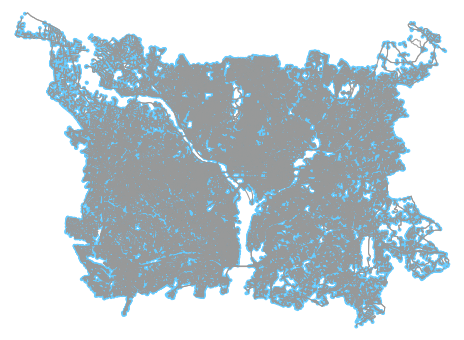

In [21]:
# Calculate the shortest path and Euclidean distance
## import DC road and service map
DCG = ox.load_graphml('G:/My Drive/Uber movement/Codes and datasets/Datasets/GDC_drive_service.graphml')
fig, ax = ox.plot_graph(DCG)

In [22]:
DCG_proj = ox.project_graph(DCG) # convert graph to UTM zone

In [23]:
## remove the data with the same Origin Movement ID (186) and Destination Movement ID (186), 
    ## because their distance can't be generated
Same_Mov_id=[i for i in df_Q1.index if df_Q1['Origin Movement ID'][i]==df_Q1['Destination Movement ID'][i]]
print(len(Same_Mov_id))
print(Same_Mov_id)
df_Q1=df_Q1.drop(Same_Mov_id,axis=0)    
df_Q1.shape

87
[181, 705, 1226, 1733, 2238, 2763, 3300, 3834, 4338, 4844, 5365, 5892, 6402, 6919, 7435, 7969, 8503, 9033, 9565, 10073, 10604, 11136, 11665, 12196, 12706, 13238, 13757, 14286, 14827, 15351, 15873, 16396, 16913, 17439, 17966, 18505, 19041, 19566, 20099, 20635, 21161, 21673, 22171, 22696, 23233, 23750, 24278, 25344, 25883, 26420, 26946, 27484, 28012, 28534, 29076, 29607, 30137, 30662, 31195, 31736, 32270, 32782, 33322, 33849, 34381, 34911, 35447, 35980, 36506, 37032, 37570, 38098, 39160, 40200, 40719, 41250, 41779, 42300, 42839, 43373, 43907, 44423, 44947, 45478, 46011, 46537, 47066]


(47297, 50)

In [24]:
## check whether there is a shortest path between the node with the max betweenness_centrality of origin ID and destination ID 
rt_set=set(zip(df_Q1['src_mxbc_node'],df_Q1['dst_mxbc_node']))
print(len(rt_set))
Non_Path=[rt for rt in rt_set if not nx.has_path(DCG, rt[0], rt[1])] # 2 unique routes don't have the shortest paths
print(len(Non_Path))
print(Non_Path)
print(WDC_GEO.loc[WDC_GEO['mxbc_node']==63627275,'MOVEMENT_ID'], 
      WDC_GEO.loc[WDC_GEO['mxbc_node']==5436130189]['MOVEMENT_ID']) # 2 zones (519,546) will be removed 
print(df_Q1.loc[df_Q1['dst_mxbc_node']==63627275].index)
print(df_Q1.loc[df_Q1['dst_mxbc_node']==5436130189].index)
print('Non_Path Removed:', len(df_Q1.loc[df_Q1['dst_mxbc_node']==63627275].index)
      +len(df_Q1.loc[df_Q1['dst_mxbc_node']==5436130189].index))
df_Q1=df_Q1.drop(df_Q1.loc[df_Q1['dst_mxbc_node']==63627275].index,axis=0)
df_Q1=df_Q1.drop(df_Q1.loc[df_Q1['dst_mxbc_node']==5436130189].index,axis=0)
df_Q1.shape

555
2
[(49762202, 63627275), (49762202, 5436130189)]
518    519
Name: MOVEMENT_ID, dtype: object 545    546
Name: MOVEMENT_ID, dtype: object
Int64Index([11981, 28853, 33104, 38418], dtype='int64')
Int64Index([  515,  1034,  1544,  2047,  2567,  3104,  3643,  4148,  4651,
             5172,  5701,  6211,  6727,  7241,  7772,  8308,  8836,  9372,
             9880, 10408, 10946, 11469, 12006, 12513, 13047, 13562, 14091,
            14635, 15158, 15680, 16203, 16721, 17246, 17772, 18310, 18847,
            19370, 19902, 20443, 20969, 21487, 21981, 22502, 23039, 23559,
            24084, 24612, 25149, 25686, 26226, 26751, 27289, 27821, 28341,
            28879, 29414, 29941, 30471, 30998, 31539, 32078, 32587, 33129,
            33653, 34186, 34715, 35254, 35787, 36312, 36839, 37379, 37902,
            38442, 38967, 39483, 40010, 40528, 41057, 41587, 42105, 42645,
            43177, 43715, 44231, 44754, 45284, 45816, 46344, 46873, 47372],
           dtype='int64')
Non_Path Removed: 94


(47203, 50)

In [25]:
## calculate the shortest path and Euclidean distance
def pathdist(df):
    dst=set(df['dst_mxbc_node'])
    spath={}
    epath={}
    for d in dst:
        spath[d]=nx.shortest_path_length(DCG, 49762202, d, weight='length')
        epath[d]=ox.euclidean_dist_vec(DCG_proj.node[d]['y'], DCG_proj.node[d]['x'],DCG_proj.node[49762202]['y'], DCG_proj.node[49762202]['x'])
        if len(epath)==50: 
            print(len(epath))
        elif len(epath)==100:
            print(len(epath))           
        elif len(epath)==200:
            print(len(epath))
        elif len(epath)==500:
            print(len(epath))
#    print(spath)
#    print(epath)
    df_Q1['spath']=[spath.get(v,'NaN') for v in df['dst_mxbc_node']]
    df_Q1['epath']=[epath.get(u,'NaN') for u in df['dst_mxbc_node']]
    return 
pathdist(df_Q1)
df_Q1.info()

50
100
200
500
<class 'pandas.core.frame.DataFrame'>
Int64Index: 47203 entries, 0 to 47383
Data columns (total 52 columns):
Origin Movement ID                           47203 non-null int64
Origin Display Name                          47203 non-null object
Destination Movement ID                      47203 non-null int64
Destination Display Name                     47203 non-null object
Date Range                                   47203 non-null object
Mean Travel Time (Seconds)                   47203 non-null int64
Range - Lower Bound Travel Time (Seconds)    47203 non-null int64
Range - Upper Bound Travel Time (Seconds)    47203 non-null int64
Date                                         47203 non-null datetime64[ns]
AWND                                         47203 non-null float64
PRCP                                         47203 non-null float64
SNOW                                         47203 non-null float64
SNWD                                         47203 non-null float6

10226.499


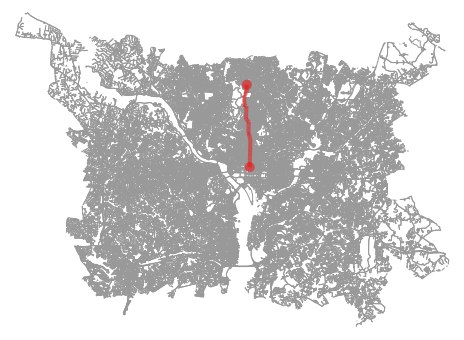

In [26]:
#Showing the example of shortest path of destination
route1 = nx.shortest_path(DCG, 49762202, df_Q1['dst_mxbc_node'][1], weight='length')
#route4 = nx.shortest_path(DCG, 49762202, df_Q1['dst_mxbc_node'][4], weight='length')
print(df_Q1['spath'][1])
fig, ax = ox.plot_graph_route(DCG, route1, node_size=0)
#fig, ax = ox.plot_graph_route(DCG, route4, node_size=0)

In [27]:
## calculate the circuit by the shortest path and Euclidean distance
df_Q1['circuit']=df_Q1['spath']/df_Q1['epath']
df_Q1.head()

,Origin Movement ID,Origin Display Name,Destination Movement ID,Destination Display Name,Date Range,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),Date,AWND,...,dst_centroid,src_centrnode,dst_centrnode,src_railway,dst_railway,src_railsubway_density_km,dst_railsubway_density_km,spath,epath,circuit
0,186,"20001, Northwest Washington, Washington",1,"5400 Arnold Avenue Southwest, Southwest Washin...","1/7/2018 - 1/7/2018, Every day, Daily Average",645,480,865,2018-01-07,8.95,...,POINT (-77.02294130943518 38.84052085153819),3669554873,49780370,0,0,0.0,0.0,10504.058,6549.172599,1.603876
1,186,"20001, Northwest Washington, Washington",2,"1400 Juniper Street Northwest, Northwest Washi...","1/7/2018 - 1/7/2018, Every day, Daily Average",1580,1292,1931,2018-01-07,8.95,...,POINT (-77.03783577191703 38.98454887155413),3669554873,49781497,0,0,0.0,0.0,10226.499,9733.047387,1.050699
2,186,"20001, Northwest Washington, Washington",3,"4800 Canal Road Northwest, Northwest Washingto...","1/7/2018 - 1/7/2018, Every day, Daily Average",1173,947,1452,2018-01-07,8.95,...,POINT (-77.10750440345829 38.92796868986088),3669554873,49749809,0,0,0.0,0.0,8465.565,7501.845296,1.128464
3,186,"20001, Northwest Washington, Washington",4,"2700 Unicorn Lane Northwest, Northwest Washing...","1/7/2018 - 1/7/2018, Every day, Daily Average",1634,1403,1902,2018-01-07,8.95,...,POINT (-77.05407807862206 38.97350188393705),3669554873,49826388,0,0,0.0,0.0,9694.971,8490.096313,1.141915
4,186,"20001, Northwest Washington, Washington",5,"4500 Q Place Northwest, Northwest Washington, ...","1/7/2018 - 1/7/2018, Every day, Daily Average",913,720,1157,2018-01-07,8.95,...,POINT (-77.08756121676936 38.91079508823327),3669554873,49743495,0,0,0.0,0.0,5718.957,5272.930256,1.084588


In [28]:
dropcol=[
'Origin Display Name',
'Destination Display Name',
'Date Range',
'src_geometry',
'dst_geometry',
'src_graph_area_m',
'src_clean_intersection_count',
'dst_clean_intersection_count',
'src_clean_intersection_density_km',
'src_street_length_total',
'dst_street_length_total',
'src_street_density_km',
'src_centroid',
'dst_centroid',
'src_railway',
'dst_railway',
'src_railsubway_density_km',
'src_centrnode',
'dst_centrnode'
]
df_Q11=df_Q1.drop(dropcol,axis=1)
df_Q11.info()
df_Q11.to_csv('G:/My Drive/Uber movement/Codes and datasets/Datasets/DC_2018Q1_clean.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47203 entries, 0 to 47383
Data columns (total 34 columns):
Origin Movement ID                           47203 non-null int64
Destination Movement ID                      47203 non-null int64
Mean Travel Time (Seconds)                   47203 non-null int64
Range - Lower Bound Travel Time (Seconds)    47203 non-null int64
Range - Upper Bound Travel Time (Seconds)    47203 non-null int64
Date                                         47203 non-null datetime64[ns]
AWND                                         47203 non-null float64
PRCP                                         47203 non-null float64
SNOW                                         47203 non-null float64
SNWD                                         47203 non-null float64
TAVG                                         47203 non-null int64
TMAX                                         47203 non-null int64
TMIN                                         47203 non-null int64
WSF2            